In [25]:
import pandas as pd

df = pd.read_csv(r"C:\Users\mruga\Desktop\New folder\Capstone Project\AutoShopIQ_Repair_chatbot\Data\Invoices_converted_csv\structured_repair_data.csv")
df.head()


,ro_number,make,model,year,mileage_in,mileage_out,concern,job_type,labor_job_info,labor_hours,labor_total_cost,source,part_name,part_total_cost
0,1,Mercedes-Benz,380SL Base,1982.0,90398.0,90399.0,Used Vehicle Inspection,Brake,R/R Rear Pads & Rotors,1.5,150.0,labor,NaN,NaN
1,1,Mercedes-Benz,380SL Base,1982.0,90398.0,90399.0,Used Vehicle Inspection,Brake,R/R Right Rear Caliper & Bleed Brake System,1.0,100.0,labor,NaN,NaN
2,1,Mercedes-Benz,380SL Base,1982.0,90398.0,90399.0,Used Vehicle Inspection,Brake,NaN,NaN,NaN,part,Brake Pad Set (Rear) Premium Brake Pad Set,99.99
3,1,Mercedes-Benz,380SL Base,1982.0,90398.0,90399.0,Used Vehicle Inspection,Brake,NaN,NaN,NaN,part,Brake Rotors (Rear) Premium Brake Rotors,150.00
4,1,Mercedes-Benz,380SL Base,1982.0,90398.0,90399.0,Used Vehicle Inspection,Brake,NaN,NaN,NaN,part,Cardone Right Rear Brake Caliper,135.75


In [26]:
import pandas as pd

# Load your CSV (update the path to your actual file)
# df = pd.read_csv("structured_repair_data.csv")

# Normalize by stripping spaces and converting to lowercase for consistent grouping
df['job_type_norm'] = df['job_type'].astype(str).str.strip().str.lower()
df['labor_job_info_norm'] = df['labor_job_info'].astype(str).str.strip().str.lower()
df['part_name_norm'] = df['part_name'].astype(str).str.strip().str.lower()

# Count unique values after normalization
job_type_counts = df['job_type_norm'].value_counts().reset_index()
job_type_counts.columns = ['job_type_normalized', 'count']

labor_info_counts = df['labor_job_info_norm'].value_counts().reset_index()
labor_info_counts.columns = ['labor_job_info_normalized', 'count']

part_name_counts = df['part_name_norm'].value_counts().reset_index()
part_name_counts.columns = ['part_name_normalized', 'count']

# Display DataFrames
print("🔧 Normalized Unique Job Types:")
display(job_type_counts)

print("🧰 Normalized Unique Labor Job Info:")
display(labor_info_counts)

print("🧩 Normalized Unique Part Names:")
display(part_name_counts)


🔧 Normalized Unique Job Types:


,job_type_normalized,count
0,oil change,10834
1,brake,5184
2,brake inspection,2552
3,general diagnostic,2096
4,diag,1288
...,...,...
1862,fender liner install,1
1863,lic. plae install,1
1864,evap smoke test,1
1865,door handle lock repair,1


🧰 Normalized Unique Labor Job Info:


,labor_job_info_normalized,count
0,nan,30432
1,oil c,1189
2,oil change labor,1017
3,r/r front brake pads & rotors,586
4,oil change,575
...,...,...
4850,"remove catalytic converter, replace rear flang...",1
4851,"r & r torque rod mount, and transmission mount",1
4852,possible oil smell /// rattle,1
4853,r & r a/c belt & tensioner,1


🧩 Normalized Unique Part Names:


,part_name_normalized,count
0,nan,21205
1,standard oil filter,1453
2,oil filter standard oil filter,1411
3,synthetic oil syn motor oil,955
4,syn blend motor oil sb-101,911
...,...,...
4355,monroe strut/coil assy,1
4356,act1455 ceramic brake pads,1
4357,autozone power steering fluid,1
4358,cardone reman remanufactured rack and pinion a...,1


In [27]:
import pandas as pd
from rapidfuzz import fuzz

# # Load your CSV (update the path to your actual file)
# df = pd.read_csv("structured_repair_data.csv")

# Normalize by stripping spaces and converting to lowercase for consistent grouping
df['job_type_norm'] = df['job_type'].astype(str).str.strip().str.lower()
df['labor_job_info_norm'] = df['labor_job_info'].astype(str).str.strip().str.lower()
df['part_name_norm'] = df['part_name'].astype(str).str.strip().str.lower()

# Count unique values after normalization
job_type_counts = df['job_type_norm'].value_counts().reset_index()
job_type_counts.columns = ['job_type_normalized', 'count']

labor_info_counts = df['labor_job_info_norm'].value_counts().reset_index()
labor_info_counts.columns = ['labor_job_info_normalized', 'count']

part_name_counts = df['part_name_norm'].value_counts().reset_index()
part_name_counts.columns = ['part_name_normalized', 'count']

# Display DataFrames
print("🔧 Normalized Unique Job Types:")
display(job_type_counts)

print("🧰 Normalized Unique Labor Job Info:")
display(labor_info_counts)

print("🧩 Normalized Unique Part Names:")
display(part_name_counts)

# Helper function to get similar terms using fuzzy matching
def get_similar_terms(base_term, choices, threshold=85, top_n=10):
    matches = [(desc, fuzz.ratio(base_term, desc)) for desc in choices if pd.notna(desc)]
    filtered = sorted([m for m in matches if m[1] >= threshold], key=lambda x: x[1], reverse=True)
    return pd.DataFrame(filtered[:top_n], columns=["matched_term", "similarity_score"])

# Apply fuzzy matching to top labor and part terms
top_labor_terms = [term for term in labor_info_counts['labor_job_info_normalized'].head(10).tolist() if pd.notna(term)]
top_part_terms = [term for term in part_name_counts['part_name_normalized'].head(10).tolist() if pd.notna(term)]

# Merge similar labor terms
similar_labor_mapping = {}
for base in top_labor_terms:
    matches_df = get_similar_terms(base, labor_info_counts['labor_job_info_normalized'])
    for match in matches_df['matched_term']:
        similar_labor_mapping[match] = base

# Apply the mapping to create a standardized labor job info column
df['labor_job_info_grouped'] = df['labor_job_info_norm'].map(similar_labor_mapping).fillna(df['labor_job_info_norm'])

# Compare number of unique labor job info values
original_count = df['labor_job_info_norm'].nunique()
grouped_count = df['labor_job_info_grouped'].nunique()

print(f"\n🔁 Labor Job Info - Original Unique Count: {original_count}")
print(f"🔁 Labor Job Info - Grouped Unique Count: {grouped_count}")


🔧 Normalized Unique Job Types:


,job_type_normalized,count
0,oil change,10834
1,brake,5184
2,brake inspection,2552
3,general diagnostic,2096
4,diag,1288
...,...,...
1862,fender liner install,1
1863,lic. plae install,1
1864,evap smoke test,1
1865,door handle lock repair,1


🧰 Normalized Unique Labor Job Info:


,labor_job_info_normalized,count
0,nan,30432
1,oil c,1189
2,oil change labor,1017
3,r/r front brake pads & rotors,586
4,oil change,575
...,...,...
4850,"remove catalytic converter, replace rear flang...",1
4851,"r & r torque rod mount, and transmission mount",1
4852,possible oil smell /// rattle,1
4853,r & r a/c belt & tensioner,1


🧩 Normalized Unique Part Names:


,part_name_normalized,count
0,nan,21205
1,standard oil filter,1453
2,oil filter standard oil filter,1411
3,synthetic oil syn motor oil,955
4,syn blend motor oil sb-101,911
...,...,...
4355,monroe strut/coil assy,1
4356,act1455 ceramic brake pads,1
4357,autozone power steering fluid,1
4358,cardone reman remanufactured rack and pinion a...,1



🔁 Labor Job Info - Original Unique Count: 4855
🔁 Labor Job Info - Grouped Unique Count: 4827


In [29]:
top_labor_terms = [term for term in labor_info_counts['labor_job_info_normalized'].head(4000).tolist() if pd.notna(term)]
top_part_terms = [term for term in part_name_counts['part_name_normalized'].head(10).tolist() if pd.notna(term)]

# Merge similar labor terms
similar_labor_mapping = {}
for base in top_labor_terms:
    matches_df = get_similar_terms(base, labor_info_counts['labor_job_info_normalized'])
    for match in matches_df['matched_term']:
        similar_labor_mapping[match] = base

# Apply the mapping to create a standardized labor job info column
df['labor_job_info_grouped'] = df['labor_job_info_norm'].map(similar_labor_mapping).fillna(df['labor_job_info_norm'])

# Compare number of unique labor job info values
original_count = df['labor_job_info_norm'].nunique()
grouped_count = df['labor_job_info_grouped'].nunique()

print(f"\n🔁 Labor Job Info - Original Unique Count: {original_count}")
print(f"🔁 Labor Job Info - Grouped Unique Count: {grouped_count}")

KeyboardInterrupt: 

In [28]:
top_labor_terms = [term for term in labor_info_counts['labor_job_info_normalized'].head(100).tolist() if pd.notna(term)]
top_part_terms = [term for term in part_name_counts['part_name_normalized'].head(100).tolist() if pd.notna(term)]

# Merge similar labor terms
similar_labor_mapping = {}
for base in top_labor_terms:
    matches_df = get_similar_terms(base, labor_info_counts['labor_job_info_normalized'])
    for match in matches_df['matched_term']:
        similar_labor_mapping[match] = base

# Apply the mapping to create a standardized labor job info column
df['labor_job_info_grouped'] = df['labor_job_info_norm'].map(similar_labor_mapping).fillna(df['labor_job_info_norm'])

# Compare number of unique labor job info values
original_count_labor = df['labor_job_info_norm'].nunique()
grouped_count_labor = df['labor_job_info_grouped'].nunique()

print(f"\n🔁 Labor Job Info - Original Unique Count: {original_count_labor}")
print(f"🔁 Labor Job Info - Grouped Unique Count: {grouped_count_labor}")

# Merge similar part names
similar_part_mapping = {}
for base in top_part_terms:
    matches_df = get_similar_terms(base, part_name_counts['part_name_normalized'])
    for match in matches_df['matched_term']:
        similar_part_mapping[match] = base

# Apply the mapping to create a standardized part name column
df['part_name_grouped'] = df['part_name_norm'].map(similar_part_mapping).fillna(df['part_name_norm'])

# Compare number of unique part name values
original_count_parts = df['part_name_norm'].nunique()
grouped_count_parts = df['part_name_grouped'].nunique()

print(f"\n🔁 Part Name - Original Unique Count: {original_count_parts}")
print(f"🔁 Part Name - Grouped Unique Count: {grouped_count_parts}")



🔁 Labor Job Info - Original Unique Count: 4855
🔁 Labor Job Info - Grouped Unique Count: 4727

🔁 Part Name - Original Unique Count: 4360
🔁 Part Name - Grouped Unique Count: 4103


In [30]:
df[['labor_job_info_norm', 'labor_job_info_grouped']].drop_duplicates().head(20)


,labor_job_info_norm,labor_job_info_grouped
0,r/r rear pads & rotors,r/r pads & rotors
1,r/r right rear caliper & bleed brake system,r/r right rear caliper & bleed brake system
2,nan,nan
5,r/r front shocks,r/r front shocks
6,r/r rear shocks,r/r rear shocks
7,replace left rear sway bar link,replace left rear sway bar link
11,oil change,oil change
14,caliper slide service,caliper slide service
15,replace blown cig. fuse,replace blown cig. fuse
41,r/r pads & rotors,r/r pads & rotors


In [34]:
top_labor_terms = [term for term in labor_info_counts['labor_job_info_normalized'].head(100).tolist() if pd.notna(term)]
top_part_terms = [term for term in part_name_counts['part_name_normalized'].head(100).tolist() if pd.notna(term)]

# Merge similar labor terms
similar_labor_mapping = {}
for base in top_labor_terms:
    matches_df = get_similar_terms(base, labor_info_counts['labor_job_info_normalized'])
    for match in matches_df['matched_term']:
        similar_labor_mapping[match] = base

# Apply the mapping to create a standardized labor job info column
df['labor_job_info_grouped'] = df['labor_job_info_norm'].map(similar_labor_mapping).fillna(df['labor_job_info_norm'])

# Compare number of unique labor job info values
original_count_labor = df['labor_job_info_norm'].nunique()
grouped_count_labor = df['labor_job_info_grouped'].nunique()

print(f"\n🔁 Labor Job Info - Original Unique Count: {original_count_labor}")
print(f"🔁 Labor Job Info - Grouped Unique Count: {grouped_count_labor}")

# Merge similar part names
similar_part_mapping = {}
for base in top_part_terms:
    matches_df = get_similar_terms(base, part_name_counts['part_name_normalized'])
    for match in matches_df['matched_term']:
        similar_part_mapping[match] = base

# Apply the mapping to create a standardized part name column
df['part_name_grouped'] = df['part_name_norm'].map(similar_part_mapping).fillna(df['part_name_norm'])

# Compare number of unique part name values
original_count_parts = df['part_name_norm'].nunique()
grouped_count_parts = df['part_name_grouped'].nunique()

print(f"\n🔁 Part Name - Original Unique Count: {original_count_parts}")
print(f"🔁 Part Name - Grouped Unique Count: {grouped_count_parts}")

# =========================
# Association Rule Mining Setup
# =========================
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Group by RO number and aggregate related info
grouped_df = df.groupby("ro_number").agg({
    "concern": lambda x: list(set(x.dropna())),
    "labor_job_info_grouped": lambda x: list(set(x.dropna())),
    "part_name_grouped": lambda x: list(set(x.dropna()))
}).reset_index()

# Combine concern, labor, and parts into one transaction
grouped_df["transaction"] = grouped_df["concern"] + grouped_df["labor_job_info_grouped"] + grouped_df["part_name_grouped"]

# Remove empty or NaN items from the list
grouped_df["transaction"] = grouped_df["transaction"].apply(lambda x: [i for i in x if pd.notna(i) and str(i).strip().lower() != 'nan'])

# Transform to format for mlxtend
te = TransactionEncoder()
te_ary = te.fit(grouped_df["transaction"]).transform(grouped_df["transaction"])
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

# Run Apriori to get frequent itemsets and rules
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Display top rules
print("\n📊 Top Association Rules:")
display(rules.sort_values("confidence", ascending=False).head(20))



🔁 Labor Job Info - Original Unique Count: 4855
🔁 Labor Job Info - Grouped Unique Count: 4727

🔁 Part Name - Original Unique Count: 4360
🔁 Part Name - Grouped Unique Count: 4103

📊 Top Association Rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
116,"(r/r rear brake pad & rotor, brake rotor package)",(brake pad set package),0.045066,0.077555,0.045066,1.000000,12.894144,1.0,0.041570,inf,0.965978,0.581081,1.000000,0.790541
189,"(r/r rear brake pad & rotor, BRAKE INSPECTION,...",(brake rotor package),0.010131,0.077555,0.010131,1.000000,12.894144,1.0,0.009345,inf,0.931886,0.130631,1.000000,0.565315
106,"(caliper slide service, brake pad set package)",(brake rotor package),0.010830,0.077555,0.010830,1.000000,12.894144,1.0,0.009990,inf,0.932545,0.139640,1.000000,0.569820
234,"(r/r rear brake pad & rotor, brake rotor packa...",(brake pad set package),0.020437,0.077555,0.020437,1.000000,12.894144,1.0,0.018852,inf,0.941690,0.263514,1.000000,0.631757
183,"(BRAKE INSPECTION, brake pad set package, r&r ...",(brake rotor package),0.010655,0.077555,0.010655,1.000000,12.894144,1.0,0.009829,inf,0.932380,0.137387,1.000000,0.568694
200,"(conventional oil motor oil, OIL CHANGE, oil f...",(oil change labor),0.010131,0.095546,0.010131,1.000000,10.466179,1.0,0.009163,inf,0.913711,0.106033,1.000000,0.553016
244,"(remove tires and inspect brakes, brake rotor ...",(brake pad set package),0.011354,0.077555,0.011354,1.000000,12.894144,1.0,0.010473,inf,0.933039,0.146396,1.000000,0.573198
223,"(brake rotor package, r&r front brake pads & r...",(brake pad set package),0.011354,0.077555,0.011354,1.000000,12.894144,1.0,0.010473,inf,0.933039,0.146396,1.000000,0.573198
40,(front brake rotor package brake rotors),(front brake pad set package brake pad set),0.012926,0.013450,0.012926,1.000000,74.350649,1.0,0.012752,inf,0.999469,0.961039,1.000000,0.980519
228,"(r/r rear brake pad & rotor, brake rotor packa...",(brake pad set package),0.012052,0.077555,0.012052,1.000000,12.894144,1.0,0.011118,inf,0.933699,0.155405,1.000000,0.577703


In [35]:

display(rules.sort_values("confidence", ascending=False).head(20))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
116,"(r/r rear brake pad & rotor, brake rotor package)",(brake pad set package),0.045066,0.077555,0.045066,1.000000,12.894144,1.0,0.041570,inf,0.965978,0.581081,1.000000,0.790541
189,"(r/r rear brake pad & rotor, BRAKE INSPECTION,...",(brake rotor package),0.010131,0.077555,0.010131,1.000000,12.894144,1.0,0.009345,inf,0.931886,0.130631,1.000000,0.565315
106,"(caliper slide service, brake pad set package)",(brake rotor package),0.010830,0.077555,0.010830,1.000000,12.894144,1.0,0.009990,inf,0.932545,0.139640,1.000000,0.569820
234,"(r/r rear brake pad & rotor, brake rotor packa...",(brake pad set package),0.020437,0.077555,0.020437,1.000000,12.894144,1.0,0.018852,inf,0.941690,0.263514,1.000000,0.631757
183,"(BRAKE INSPECTION, brake pad set package, r&r ...",(brake rotor package),0.010655,0.077555,0.010655,1.000000,12.894144,1.0,0.009829,inf,0.932380,0.137387,1.000000,0.568694
200,"(conventional oil motor oil, OIL CHANGE, oil f...",(oil change labor),0.010131,0.095546,0.010131,1.000000,10.466179,1.0,0.009163,inf,0.913711,0.106033,1.000000,0.553016
244,"(remove tires and inspect brakes, brake rotor ...",(brake pad set package),0.011354,0.077555,0.011354,1.000000,12.894144,1.0,0.010473,inf,0.933039,0.146396,1.000000,0.573198
223,"(brake rotor package, r&r front brake pads & r...",(brake pad set package),0.011354,0.077555,0.011354,1.000000,12.894144,1.0,0.010473,inf,0.933039,0.146396,1.000000,0.573198
40,(front brake rotor package brake rotors),(front brake pad set package brake pad set),0.012926,0.013450,0.012926,1.000000,74.350649,1.0,0.012752,inf,0.999469,0.961039,1.000000,0.980519
228,"(r/r rear brake pad & rotor, brake rotor packa...",(brake pad set package),0.012052,0.077555,0.012052,1.000000,12.894144,1.0,0.011118,inf,0.933699,0.155405,1.000000,0.577703


In [36]:
display(rules.sort_values("lift", ascending=False).head(20))
display(rules.sort_values("support", ascending=False).head(20))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
182,(rear brake pad set package brake pad set),"(rear brake rotor package brake rotors, r/r pa...",0.012576,0.011703,0.011703,0.930556,79.513889,1.0,0.011556,14.231476,1.000000,0.930556,0.929733,0.965278
181,"(rear brake rotor package brake rotors, r/r pa...",(rear brake pad set package brake pad set),0.011703,0.012576,0.011703,1.000000,79.513889,1.0,0.011556,inf,0.999116,0.930556,1.000000,0.965278
157,"(r/r pads & rotors, front brake pad set packag...",(front brake rotor package brake rotors),0.012926,0.012926,0.012576,0.972973,75.273923,1.0,0.012409,36.521747,0.999636,0.947368,0.972619,0.972973
158,(front brake rotor package brake rotors),"(r/r pads & rotors, front brake pad set packag...",0.012926,0.012926,0.012576,0.972973,75.273923,1.0,0.012409,36.521747,0.999636,0.947368,0.972619,0.972973
155,"(front brake rotor package brake rotors, r/r p...",(front brake pad set package brake pad set),0.012576,0.013450,0.012576,1.000000,74.350649,1.0,0.012407,inf,0.999116,0.935065,1.000000,0.967532
40,(front brake rotor package brake rotors),(front brake pad set package brake pad set),0.012926,0.013450,0.012926,1.000000,74.350649,1.0,0.012752,inf,0.999469,0.961039,1.000000,0.980519
159,(front brake pad set package brake pad set),"(front brake rotor package brake rotors, r/r p...",0.013450,0.012576,0.012576,0.935065,74.350649,1.0,0.012407,15.206323,1.000000,0.935065,0.934238,0.967532
41,(front brake pad set package brake pad set),(front brake rotor package brake rotors),0.013450,0.012926,0.012926,0.961039,74.350649,1.0,0.012752,25.334905,1.000000,0.961039,0.960529,0.980519
176,"(r/r pads & rotors, rear brake pad set)",(rear brake rotor),0.010306,0.015546,0.010131,0.983051,63.235574,1.0,0.009971,58.082795,0.994434,0.644444,0.982783,0.817368
177,(rear brake rotor),"(r/r pads & rotors, rear brake pad set)",0.015546,0.010306,0.010131,0.651685,63.235574,1.0,0.009971,2.841380,0.999728,0.644444,0.648058,0.817368


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,(standard oil filter),(OIL CHANGE),0.152664,0.189345,0.089083,0.583524,3.081804,1.0,0.060177,1.946463,0.797222,0.352210,0.486248,0.527002
18,(brake rotor package),(brake pad set package),0.077555,0.077555,0.076332,0.984234,12.690858,1.0,0.070317,58.509395,0.998653,0.968958,0.982909,0.984234
19,(brake pad set package),(brake rotor package),0.077555,0.077555,0.076332,0.984234,12.690858,1.0,0.070317,58.509395,0.998653,0.968958,0.982909,0.984234
34,(conventional oil motor oil),(oil change labor),0.077380,0.095546,0.074061,0.957111,10.017291,1.0,0.066668,21.088063,0.975670,0.749117,0.952580,0.866124
35,(oil change labor),(conventional oil motor oil),0.095546,0.077380,0.074061,0.775137,10.017291,1.0,0.066668,4.103034,0.995266,0.749117,0.756278,0.866124
7,(oil c),(OIL CHANGE),0.120349,0.189345,0.071441,0.593614,3.135092,1.0,0.048654,1.994790,0.774205,0.299853,0.498694,0.485460
49,(oil filter standard oil filter),(synthetic oil syn motor oil),0.135197,0.069345,0.067598,0.500000,7.210327,1.0,0.058223,1.861310,0.995960,0.493622,0.462744,0.737406
48,(synthetic oil syn motor oil),(oil filter standard oil filter),0.069345,0.135197,0.067598,0.974811,7.210327,1.0,0.058223,34.332699,0.925488,0.493622,0.970873,0.737406
45,(oil c),(standard oil filter),0.120349,0.152664,0.062183,0.516691,3.384502,1.0,0.043810,1.753197,0.800927,0.294946,0.429614,0.462007
3,(No customer concerns found.),(No technician concerns found.),0.055371,0.057991,0.052576,0.949527,16.373617,1.0,0.049365,18.663548,0.993963,0.864943,0.946420,0.928077


In [38]:
concern_keywords = ['noise', 'check', 'leak', 'diagnostic', 'vibration']
rules_concern = rules[rules['antecedents'].apply(lambda x: any(k in str(x).lower() for k in concern_keywords))]
display(rules_concern.sort_values("confidence", ascending=False).head(10))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
102,"(visually inspect exhaust system for leaks, ex...",(ab&s adapter),0.015721,0.026900,0.010655,0.677778,25.196609,1.0,0.010232,3.019967,0.975650,0.333333,0.668871,0.536941
103,"(visually inspect exhaust system for leaks, ab...",(exhaust weld),0.016070,0.026725,0.010655,0.663043,24.809960,1.0,0.010226,2.888429,0.975368,0.331522,0.653791,0.530868
1,(EXHAUST LEAK),(visually inspect exhaust system for leaks),0.046812,0.071616,0.027249,0.582090,8.127958,1.0,0.023896,2.221491,0.920037,0.298851,0.549852,0.481289


c:\Users\mruga\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mruga\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mruga\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


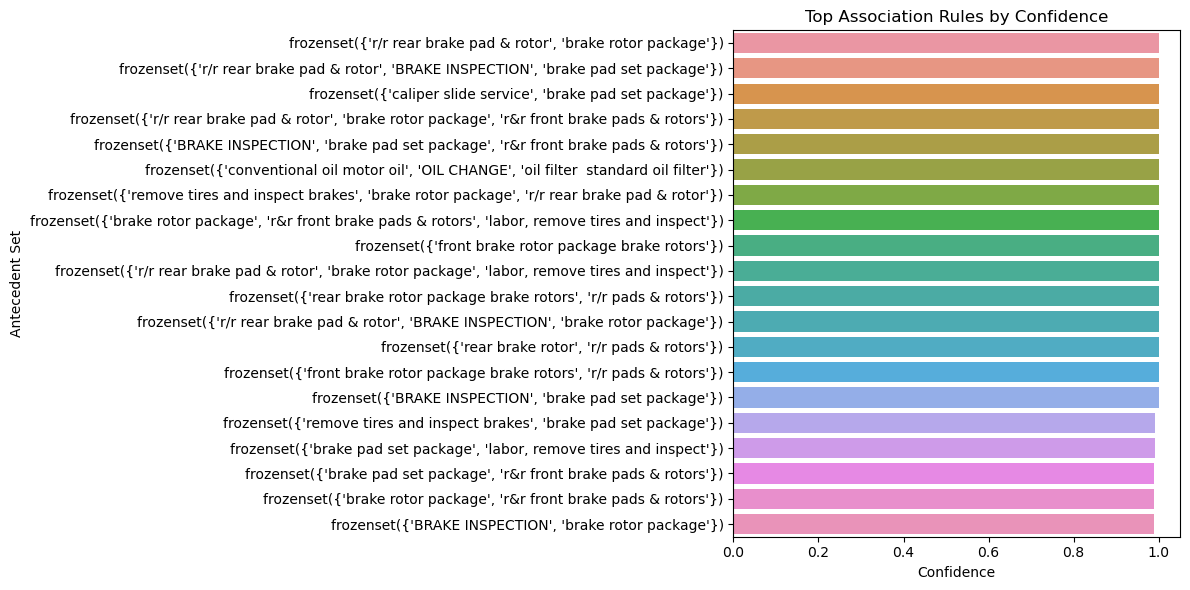

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

top_rules = rules.sort_values("confidence", ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_rules, x="confidence", y=top_rules["antecedents"].astype(str))
plt.title("Top Association Rules by Confidence")
plt.xlabel("Confidence")
plt.ylabel("Antecedent Set")
plt.tight_layout()
plt.show()


In [ ]:
top_labor_terms = [term for term in labor_info_counts['labor_job_info_normalized'].head(100).tolist() if pd.notna(term)]
top_part_terms = [term for term in part_name_counts['part_name_normalized'].head(100).tolist() if pd.notna(term)]

# Merge similar labor terms
similar_labor_mapping = {}
for base in top_labor_terms:
    matches_df = get_similar_terms(base, labor_info_counts['labor_job_info_normalized'])
    for match in matches_df['matched_term']:
        similar_labor_mapping[match] = base

# Apply the mapping to create a standardized labor job info column
df['labor_job_info_grouped'] = df['labor_job_info_norm'].map(similar_labor_mapping).fillna(df['labor_job_info_norm'])

# Compare number of unique labor job info values
original_count_labor = df['labor_job_info_norm'].nunique()
grouped_count_labor = df['labor_job_info_grouped'].nunique()

print(f"\n🔁 Labor Job Info - Original Unique Count: {original_count_labor}")
print(f"🔁 Labor Job Info - Grouped Unique Count: {grouped_count_labor}")

# Merge similar part names
similar_part_mapping = {}
for base in top_part_terms:
    matches_df = get_similar_terms(base, part_name_counts['part_name_normalized'])
    for match in matches_df['matched_term']:
        similar_part_mapping[match] = base

# Apply the mapping to create a standardized part name column
df['part_name_grouped'] = df['part_name_norm'].map(similar_part_mapping).fillna(df['part_name_norm'])

# Compare number of unique part name values
original_count_parts = df['part_name_norm'].nunique()
grouped_count_parts = df['part_name_grouped'].nunique()

print(f"\n🔁 Part Name - Original Unique Count: {original_count_parts}")
print(f"🔁 Part Name - Grouped Unique Count: {grouped_count_parts}")

# =========================
# Association Rule Mining Setup
# =========================
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Group by RO number and aggregate related info
grouped_df = df.groupby("ro_number").agg({
    "concern": lambda x: list(set(x.dropna())),
    "labor_job_info_grouped": lambda x: list(set(x.dropna())),
    "part_name_grouped": lambda x: list(set(x.dropna()))
}).reset_index()

# Combine concern, labor, and parts into one transaction
grouped_df["transaction"] = grouped_df["concern"] + grouped_df["labor_job_info_grouped"] + grouped_df["part_name_grouped"]

# Remove empty or NaN items from the list
grouped_df["transaction"] = grouped_df["transaction"].apply(lambda x: [i for i in x if pd.notna(i) and str(i).strip().lower() != 'nan'])

# Transform to format for mlxtend
te = TransactionEncoder()
te_ary = te.fit(grouped_df["transaction"]).transform(grouped_df["transaction"])
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

# Run Apriori to get frequent itemsets and rules
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Display top rules
print("📊 Top Association Rules Based on Concerns:")
# Prompt user for concern keywords interactively
user_input = input("Enter concern keywords separated by commas (e.g., check, noise, diagnostic): ")
concern_keywords = [kw.strip().lower() for kw in user_input.split(',') if kw.strip()]

# Filter rules based on user-defined keywords
rules_filtered = rules[rules['antecedents'].apply(lambda x: any(k in str(x).lower() for k in concern_keywords))]]
display(rules_filtered.sort_values("confidence", ascending=False).head(20))

# Export rules and cost stats
# 1. Concern → Job Rules
concern_to_jobs = rules[rules['antecedents'].apply(lambda x: any(k in str(x).lower() for k in concern_keywords)) &
                        rules['consequents'].apply(lambda x: any('labor' in str(x).lower()))]
import os
output_dir = r"C:\Users\mruga\Desktop\New folder\Capstone Project\AutoShopIQ_Repair_chatbot\Data\association_rule_mining"
os.makedirs(output_dir, exist_ok=True)

concern_to_jobs.to_csv(os.path.join(output_dir, "concern_to_jobs_rules.csv"), index=False)

# 2. Job → Part Rules
job_to_parts = rules[rules['antecedents'].apply(lambda x: any('labor' in str(x).lower())) & rules['consequents'].apply(lambda x: any('part' in str(x).lower()))]
job_to_parts.to_csv(os.path.join(output_dir, "job_to_parts_rules.csv"), index=False)

# 3. Cost Stats by Concern
cost_stats = df.groupby("concern")[["labor_total_cost", "part_total_cost"]].agg(["mean", "median", "count"]).dropna()
cost_stats.to_json(os.path.join(output_dir, "concern_to_cost_stats.json"), orient='index')

print("✅ Exported concern/job/part rules and cost stats.")


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 88)

In [32]:
pip install mlxtend


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.4 MB 991.0 kB/s eta 0:00:02
   -------------------- ------------------- 0.7/1.4 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 10.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---- ----------------------------------- 1.2/11.1 MB 25.1 MB/s eta 0:00:01
   -------- ------------------------------- 2.3/11.1 MB 29.3 MB/s eta 0:00:01
   ------------ --------------------------- 3.4/11.1 MB 27.4 MB/s eta 0:00:01
   ----------------- ---------------------- 4.9/11.1 MB 26.4 MB/s eta 0:00:01
   ------------------- -------------------- 5.3/11.1 MB 24.3 MB/s eta 0:00:01
   --------------------- ------------------ 6.1/11.1 MB 22.8 MB/s eta 0:00:01
   ------------------------ --------------- 6.9/11.1 MB 22.1 MB/s eta 0:00:01
   ----

In [14]:
pip install rapidfuzz


   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB 660.6 kB/s eta 0:00:03
   ------------- -------------------------- 0.6/1.6 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 11.5 MB/s eta 0:00:00
